In [1]:
# Standard things
import math
import numpy as np
import jax.numpy as jnp
import jax

# FLOAT64 seems to be necessary for integral precision
jax.config.update("jax_enable_x64", True)


from utils.function1D_utils import taylor_expand_in_alpha, eval_taylor_expansion, reduce_alpha
from utils.distribution_utils import q, log_q

from utils.qcd_utils import running_coupling   
from jax.experimental.ode import odeint

# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot, hist_with_errors


### Jax setting and compilation

In [2]:
# JAX vmapping and compilation
jitted_q  = jax.jit(q)
vmapped_q = jax.vmap(jitted_q, in_axes=(0, None, None, None))

jitted_log_q  = jax.jit(log_q)
vmapped_log_q = jax.vmap(jitted_log_q, in_axes=(0, None, None, None))

# jitted_polynomial = jax.jit(polynomial)
# vmapped_polynomial = jax.vmap(jitted_polynomial, in_axes=(0, None))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


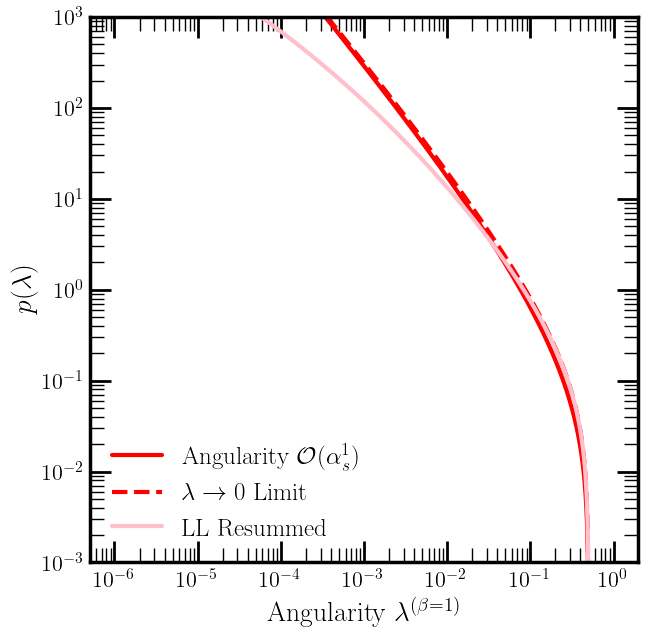

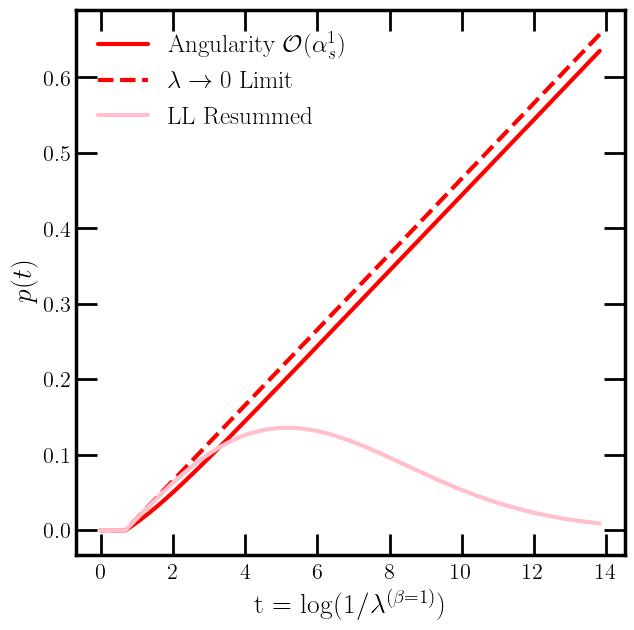

In [3]:
def angularity_full(x, alpha, param = 1):
    
    alpha_bar = alpha * 4/3 / (2 * np.pi)
    beta = param
    theta = (x < 1/2) * (x > 0) * 1

    return alpha_bar / (beta * x) * (2 * jnp.log(1/(2 * x)) - 7/8 + 2 * x - x**2/2) * theta

def angualrity_0(x, alpha, param = 1):
    
    alpha_bar = alpha * 4/3 / (2 * np.pi)
    beta = param
    theta = (x < 1/2) * (x > 0) * 1

    return alpha_bar / (beta * x) * (2 * jnp.log(1/(2 * x)) )  * theta


def angularity_resummed(x, alpha, param = 1):

    alpha_bar = alpha * 4/3 / (2 * np.pi)
    theta = (x < 1/2) * (x > 0) * 1

    prefactor = angualrity_0(x, alpha, param)
    term2 = jnp.exp(-alpha_bar * jnp.log(1/(2* x))**2) * theta

    return prefactor * term2


def t_from_x(x):

    return jnp.log(1/x)


def function_t_from_x(func):

    def t_func(t, alpha, params):

        x = jnp.exp(-t)
        # print(x)
        # print(func(x, alpha, params))
        return func(x, alpha, params) * x
    return t_func


t_angularity_full = function_t_from_x(angularity_full)
t_angularity_0 = function_t_from_x(angualrity_0)
t_angularity_resummed = function_t_from_x(angularity_resummed)



xs = jnp.linspace(0, 1, 1000000)
ts = t_from_x(xs)

alpha = 0.118
param = 1

fig, ax = newplot("full")
ax.plot(xs, angularity_full(xs, alpha, param), label = r"Angularity $\mathcal{O}(\alpha_s^1)$", color = "red")
ax.plot(xs, angualrity_0(xs, alpha, param), label = r"$\lambda \to 0$ Limit", color = "red", ls = "--")
ax.plot(xs, angularity_resummed(xs, alpha, param), label = r"LL Resummed", color = "pink")
ax.legend()
ax.set_xlabel(r"Angularity $\lambda^{(\beta = 1)}$")
ax.set_ylabel(r"$p(\lambda)$")

plt.ylim(1e-3, 1e3)

plt.xscale("log")
plt.yscale("log")

plt.savefig("plots/angularity_full.pdf")



fig, ax = newplot("full")


ax.plot(ts, t_angularity_full(ts, alpha, param), label = r"Angularity $\mathcal{O}(\alpha_s^1)$", color = "red")
ax.plot(ts, t_angularity_0(ts, alpha, param), label = r"$\lambda \to 0$ Limit", color = "red", ls = "--")
ax.plot(ts, t_angularity_resummed(ts, alpha, param), label = r"LL Resummed", color = "pink")
ax.legend()
ax.set_xlabel(r"t =  $\log(1/\lambda^{(\beta = 1)})$")
ax.set_ylabel(r"$p(t)$")
# plt.ylim(1e-3, 1e3)

# plt.axvline(jnp.log(2), color = "grey", ls = "--", lw = 2)

plt.savefig("plots/angularity_full_t.pdf")



# Test Taylor Expanding

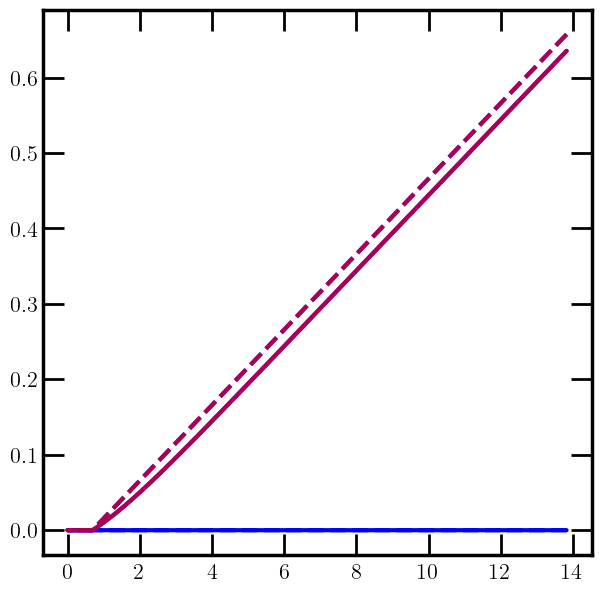

In [5]:
p_m = taylor_expand_in_alpha(t_angularity_full, 3)
p_m_0 = taylor_expand_in_alpha(t_angularity_0, 3)


fig, ax = newplot("full")

colors = [(i/3, 0, (3-i)/3) for i in range(3)]
for i in range(3):

    p_m_i = p_m[:i+1]
    p_m_0_i = p_m_0[:i+1]

    vmapped_eval = jax.vmap(eval_taylor_expansion, in_axes=(None, 0, None, None))
    p_m_i_eval = vmapped_eval(p_m_i, ts, alpha, param)
    p_m_0_i_eval = vmapped_eval(p_m_0_i, ts, alpha, param)
    ax.plot(ts, p_m_i_eval, label = f"Order {i+1}", color = colors[i])
    ax.plot(ts, p_m_0_i_eval, label = f"Order {i+1} (0 limit)", color = colors[i], ls = "--")




# Test Reduction

In [6]:
print(p_m)
r_m, p_star, m_star = reduce_alpha(p_m)
r_m_0, p_star_0, m_star_0 = reduce_alpha(p_m_0)

# Plot p_stars
fig, ax = newplot("full")
vmapped_p_star = jax.vmap(p_star, in_axes=(0, None, None))
vmapped_p_star_0 = jax.vmap(p_star_0, in_axes=(0, None, None))
ax.plot(ts, vmapped_p_star(ts, alpha, param), label = r"$p^*(t)$", color = "blue")
ax.plot(ts, vmapped_p_star_0(ts, alpha, param), label = r"$p^*(t)$ (0 limit)", color = "blue", ls = "--")



[<function taylor_expand_in_alpha.<locals>.order_n at 0x73d6b8f96b80>, <function taylor_expand_in_alpha.<locals>.order_n at 0x73d6b8efd700>, <function taylor_expand_in_alpha.<locals>.order_n at 0x73d6b8efd670>, <function taylor_expand_in_alpha.<locals>.order_n at 0x73d6b8efd790>]


TypeError: unsupported operand type(s) for *: 'NoneType' and 'BatchTracer'